In [1]:
cd ..

E:\18-09-19 Document structure\business\Study\Master\Cognitive Computing\P3\Machine learning in practice\git\Private\M5Forecast


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions_uncertainty/'
for dirname, _, filenames in os.walk(os.environ['DATA_DIR']):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.


Bad key "text.kerning_factor" on line 4 in
E:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
def plot_loss(history):
    f, ax = plt.subplots(1, 1, figsize=(18, 6))
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Validation')
    ax.set_ylim(0)
    ax.legend()
    plt.show()

# Pinball Loss function for Keras

In [4]:
train_df = pd.read_csv("custom_layer/features.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets.csv", index_col=0)

In [5]:
train_df.head()

,wday,month,snap_CA,w_1,w_2,w_3,w_4,w_5,w_6,w_7
date,,,,,,,,,,
2011-01-29,1,1,0,1,0,0,0,0,0,0
2011-01-30,2,1,0,0,1,0,0,0,0,0
2011-01-31,3,1,0,0,0,1,0,0,0,0
2011-02-01,4,2,1,0,0,0,1,0,0,0
2011-02-02,5,2,1,0,0,0,0,1,0,0


In [6]:
target_df.head()

,0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995
date,,,,,,,,,
2011-01-29,0.429084,0.500587,0.628482,0.662077,0.743227,0.824528,0.861499,0.989619,1.086067
2011-01-30,0.834881,1.032595,1.265410,1.343565,1.503276,1.660740,1.728179,2.014386,2.143587
2011-01-31,0.838167,0.991256,1.246369,1.329488,1.508577,1.680692,1.763780,1.976137,2.167394
2011-02-01,0.424697,0.501162,0.629065,0.668797,0.758173,0.842714,0.878296,1.015888,1.090475
2011-02-02,0.438830,0.511583,0.630601,0.669403,0.754088,0.842727,0.883785,1.007879,1.084537


In [7]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    x = Dense(len(quantiles))(x)  # returns 9 points, one for each quantile
    out = x

    model = Model(inputs=inp, outputs=out)

    return model

In [8]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 27        
Total params: 2,989
Trainable params: 2,989
Non-trainable params: 0
___________________________________________________________

In [9]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = model.fit(X_train, y_train, epochs=300,
                    
                    validation_data=(X_val, y_val))

Train on 269 samples, validate on 68 samples
Epoch 1/300
269/269 [==============================] - 2s 9ms/sample - loss: 1.1917 - val_loss: 0.9042
Epoch 2/300
269/269 [==============================] - 0s 749us/sample - loss: 0.8217 - val_loss: 0.7791
Epoch 3/300
269/269 [==============================] - 0s 119us/sample - loss: 0.7792 - val_loss: 0.6893
Epoch 4/300
269/269 [==============================] - 0s 115us/sample - loss: 0.7038 - val_loss: 0.6442
Epoch 5/300
269/269 [==============================] - 0s 113us/sample - loss: 0.6833 - val_loss: 0.6131
Epoch 6/300
269/269 [==============================] - 0s 130us/sample - loss: 0.6547 - val_loss: 0.5905
Epoch 7/300
269/269 [==============================] - 0s 123us/sample - loss: 0.6272 - val_loss: 0.5632
Epoch 8/300
269/269 [==============================] - 0s 117us/sample - loss: 0.5996 - val_loss: 0.5338
Epoch 9/300
269/269 [==============================] - 0s 119us/sample - loss: 0.5675 - val_loss: 0.5071
Epoch 10/300

Epoch 78/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0263 - val_loss: 0.0323
Epoch 79/300
269/269 [==============================] - 0s 110us/sample - loss: 0.0273 - val_loss: 0.0194
Epoch 80/300
269/269 [==============================] - 0s 117us/sample - loss: 0.0203 - val_loss: 0.0301
Epoch 81/300
269/269 [==============================] - 0s 113us/sample - loss: 0.0232 - val_loss: 0.0166
Epoch 82/300
269/269 [==============================] - 0s 110us/sample - loss: 0.0190 - val_loss: 0.0257
Epoch 83/300
269/269 [==============================] - 0s 100us/sample - loss: 0.0274 - val_loss: 0.0208
Epoch 84/300
269/269 [==============================] - 0s 101us/sample - loss: 0.0262 - val_loss: 0.0208
Epoch 85/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0415 - val_loss: 0.0457
Epoch 86/300
269/269 [==============================] - ETA: 0s - loss: 0.043 - 0s 102us/sample - loss: 0.0291 - val_loss: 0.0365
Epoch 87/300
269/269 [

269/269 [==============================] - 0s 119us/sample - loss: 0.0123 - val_loss: 0.0132
Epoch 155/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0145 - val_loss: 0.0216
Epoch 156/300
269/269 [==============================] - 0s 117us/sample - loss: 0.0167 - val_loss: 0.0154
Epoch 157/300
269/269 [==============================] - 0s 119us/sample - loss: 0.0131 - val_loss: 0.0112
Epoch 158/300
269/269 [==============================] - 0s 112us/sample - loss: 0.0139 - val_loss: 0.0137
Epoch 159/300
269/269 [==============================] - 0s 121us/sample - loss: 0.0134 - val_loss: 0.0105
Epoch 160/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0124 - val_loss: 0.0274
Epoch 161/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0253 - val_loss: 0.0303
Epoch 162/300
269/269 [==============================] - 0s 106us/sample - loss: 0.0203 - val_loss: 0.0225
Epoch 163/300
269/269 [============================

269/269 [==============================] - 0s 110us/sample - loss: 0.0151 - val_loss: 0.0136
Epoch 231/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0167 - val_loss: 0.0172
Epoch 232/300
269/269 [==============================] - 0s 113us/sample - loss: 0.0143 - val_loss: 0.0146
Epoch 233/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0124 - val_loss: 0.0111
Epoch 234/300
269/269 [==============================] - 0s 106us/sample - loss: 0.0126 - val_loss: 0.0199
Epoch 235/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0220 - val_loss: 0.0207
Epoch 236/300
269/269 [==============================] - 0s 108us/sample - loss: 0.0143 - val_loss: 0.0137
Epoch 237/300
269/269 [==============================] - 0s 104us/sample - loss: 0.0172 - val_loss: 0.0183
Epoch 238/300
269/269 [==============================] - 0s 113us/sample - loss: 0.0199 - val_loss: 0.0189
Epoch 239/300
269/269 [============================

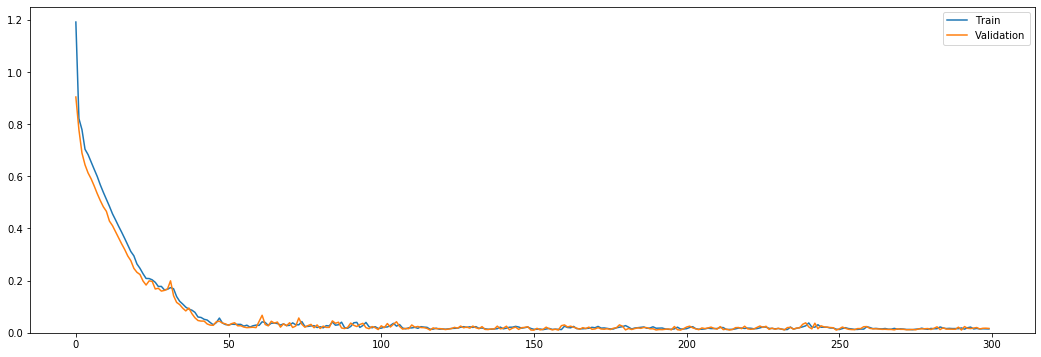

In [11]:
plot_loss(history)

In [12]:
y_pred = model.predict(X_val)

In [13]:
y_pred[0:2]

array([[0.4114417 , 0.48735207, 0.61332107, 0.6514602 , 0.7352706 ,
        0.82840574, 0.8609055 , 0.9938454 , 1.0638919 ],
       [0.8470335 , 1.0021744 , 1.2437438 , 1.3201789 , 1.4834784 ,
        1.6747763 , 1.7289132 , 2.0042746 , 2.1307094 ]], dtype=float32)

## Rewrite to multi-output for each quantile

In [34]:
# Assumes the following order of statistical distribution parameters for
# the neurons in the layer before this custom layer:
# x[0] = mu
# x[1] = sigma
# x[2] = skewness
# x[3] = kurtosis
def DistributionLayer(quantile_index,x):
    mu = x[0]
    sigma = x[1] 
    skewness = None
    kurtosis = None
    
    # absorb extra statistical distribution parameters if present
    if (len(x.get_shape().as_list())>2):
        skewness= x[2]
    if (len(x.get_shape().as_list())>3):
        kurtosis = x[3]
        
    if (skewness==None):
        if (kurtosis==None):
            # Source of Z-scores: https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
             return {
                0.005: mu-2.57583*sigma, # https://www.wolframalpha.com/input/?i=0.5+percentiles+of+a+normal+distribution
                0.025: mu-1.95996*sigma, # https://www.wolframalpha.com/input/?i=2.5+percentiles+of+a+normal+distribution
                0.165: mu-0.974114*sigma, # https://www.wolframalpha.com/input/?i=16.5+percentiles+of+a+normal+distribution
                0.25: mu-0.674*sigma, # https://www.wolframalpha.com/input/?i=25+percentiles+of+a+normal+distribution
                0.5: mu, # https://www.wolframalpha.com/input/?i=50+percentiles+of+a+normal+distribution
                0.75: mu+0.674*sigma, # https://www.wolframalpha.com/input/?i=75+percentiles+of+a+normal+distribution
                0.835: mu+0.9741114*sigma, #https://www.wolframalpha.com/input/?i=83.5+percentiles+of+a+normal+distribution
                0.975: mu+1.95996*sigma, #https://www.wolframalpha.com/input/?i=97.5+percentiles+of+a+normal+distribution
                0.995: mu+2.57583*sigma, #https://www.wolframalpha.com/input/?i=99.5+percentiles+of+a+normal+distribution
            }[quantile]
    

In [40]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    #out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q0 = DistributionLayer(quantiles[0],x)
    out_q1 = DistributionLayer(quantiles[1],x)
    out_q2 = DistributionLayer(quantiles[2],x)
    out_q3 = DistributionLayer(quantiles[3],x)
    out_q4 = DistributionLayer(quantiles[4],x)
    out_q5 = DistributionLayer(quantiles[5],x)
    out_q6 = DistributionLayer(quantiles[6],x)
    out_q7 = DistributionLayer(quantiles[7],x)
    out_q8 = DistributionLayer(quantiles[8],x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [41]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss="MAE")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           176         input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

In [42]:
y_train_mo = {'q'+str(i): y_train[:, i] for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val[:, i] for i in range(len(quantiles))}
y_train_mo

{'q0': array([0.77976871, 0.4255634 , 0.41740025, 0.42903284, 0.82754025,
        0.4064456 , 0.40616237, 0.45264247, 0.41096554, 0.41689168,
        0.38520678, 0.41300217, 0.40747019, 0.86864485, 0.43559714,
        0.42313449, 0.41549744, 0.43160425, 0.4241328 , 0.39397524,
        0.45516087, 0.92357664, 0.41138681, 0.4042906 , 0.84447597,
        0.42392267, 0.7718635 , 0.44973176, 0.43213789, 0.84063285,
        0.82372458, 0.78483486, 0.41210167, 0.43546165, 0.92956534,
        0.44674431, 0.40117869, 0.44582427, 0.83591121, 0.87259832,
        0.90353443, 0.42208748, 0.38899553, 0.45153601, 0.39837333,
        0.41525051, 0.42364229, 0.86586664, 0.40607733, 0.41816087,
        0.38255025, 0.89064516, 0.42218558, 0.42119283, 0.40201799,
        0.90192745, 0.40566299, 0.42338319, 0.41504695, 0.43416054,
        0.40994688, 0.41956467, 0.86222354, 0.40953107, 0.87499344,
        0.43268808, 0.40363463, 0.43650302, 0.41236164, 0.91755915,
        0.84431159, 0.79940419, 0.41597326

In [43]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

ValueError: No data provided for "tf_op_layer_sub". Need data for each key in: ['tf_op_layer_sub', 'tf_op_layer_sub_4', 'tf_op_layer_sub_8', 'tf_op_layer_sub_12', 'tf_op_layer_sub_16', 'tf_op_layer_sub_20', 'tf_op_layer_sub_24', 'tf_op_layer_sub_28', 'tf_op_layer_sub_32']

In [ ]:
plot_loss(history)

In [ ]:
y_pred = model.predict(X_val)

# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

**Note**: training seems slower! 

## Employ pinball loss

In [ ]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [ ]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

In [ ]:
model = get_model(inp_shape=(train_df.columns.size,), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history)

In [ ]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

**Note**: the distribution of predictions is wider than when trained with the MAE. This is in line with what we would expect: over-predicting the lower quantiles is punished much harder than before, and the same for under-predicting the higher quantiles.

## Test pinball loss

In [ ]:
# from https://github.com/keras-team/keras/pull/8033/files
def test_pinball_loss():
    y_pred = K.variable(np.array([0.3, 0.6, 0.1]))
    y_true = K.variable(np.array([0.3, 0.4, 0.5]))
    quantile = 0.25
    loss_fcn = create_pinball_loss(tau=quantile)#losses.PinballLoss(quantile)
    expected_loss = (quantile * 0.4 + (1 - quantile) * 0.2) / 3
    loss = K.eval(loss_fcn(y_true, y_pred))
    assert np.isclose(expected_loss, loss)

test_pinball_loss()

## Dataset 2

In [ ]:
train_df = pd.read_csv("custom_layer/features2.csv", index_col=0)
target_df = pd.read_csv("custom_layer/targets2.csv", index_col=0, header=None, names=['target'])
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [ ]:
train_df.head()

In [ ]:
target_df.head()

In [ ]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [ ]:
X = train_df.values
y = target_df.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_mo = {'q'+str(i): y_train for i in range(len(quantiles))}
y_val_mo = {'q'+str(i): y_val for i in range(len(quantiles))}

In [ ]:
def get_model(inp_shape, quantiles):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)
    x = Dense(2)(x)  # represents mu, sigma
    
    out_q0 = Dense(1, name="q0")(x)  # DistributionLayer(quantile=quantiles[0])(x)
    out_q1 = Dense(1, name="q1")(x)  # DistributionLayer(quantile=quantiles[1])(x)
    out_q2 = Dense(1, name="q2")(x)  # ...
    out_q3 = Dense(1, name="q3")(x)
    out_q4 = Dense(1, name="q4")(x)
    out_q5 = Dense(1, name="q5")(x)
    out_q6 = Dense(1, name="q6")(x)
    out_q7 = Dense(1, name="q7")(x)
    out_q8 = Dense(1, name="q8")(x)

    model = Model(inputs=inp, outputs=[out_q0, out_q1, out_q2, out_q3, out_q4, out_q5, out_q6, out_q7, out_q8])

    return model

In [ ]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

In [ ]:
model = get_model(inp_shape=(X_train.shape[1],), quantiles=quantiles)
model.compile(optimizer="adam", loss=losses)
model.summary()

In [ ]:
history = model.fit(X_train, y_train_mo, epochs=300,
                    validation_data=(X_val, y_val_mo))

In [ ]:
plot_loss(history)

### Predicted distribution

In [ ]:
# predict validation set
y_pred = model.predict(X_val)
# revert multi output format to (n_samples, quantiles)
y_pred = np.array(list(zip(*y_pred))).squeeze()
y_pred[0:2]

In [ ]:
# "true" quantiles
pd.Series(np.random.normal(0.75, 0.13, size=100000)).quantile(quantiles)

In [ ]:
# "true" quantiles
pd.Series(np.random.normal(1.5, 0.25, size=100000)).quantile(quantiles)

**Result**: The toy dataset contains two simple distributions, with either $\mu=0.75, \sigma=0.13$ or $\mu=1.5, \sigma=0.25$, depending on whether it is a weekday or weekend. The observed 'demand' are samples distributed as such. For these simple distributions, the Pinball Loss is able to (approximately) retrieve the correct quantiles!